*First compiled on May 25, 2017. Updated Mar 28, 2018.*

# PAGA for hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

Compared to the data of [Paul *et al.* (2015)](http://doi.org/10.1016/j.cell.2015.11.013), the data of  [Nestorowa *et al.* (2016)](https://doi.org/10.1182/blood-2016-05-716480) has been measured for earlier hematopoiesis (younger mice, 12 weeks old).

Data is available from [blood.stemcells.cam.ac.uk/single_cell_atlas](http://blood.stemcells.cam.ac.uk/single_cell_atlas). In particular, the data matrix [*nestorowa_corrected_log2_transformed_counts.txt*](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_log2_transformed_counts.txt.gz) and the population annotations [*nestorowa_corrected_population_annotation.txt*](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_population_annotation.txt.gz).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/nestorowa16.h5ad'

## Reading and annotating the data

In [2]:
def nestorowa16():
    # Read the data matrix.
    adata = sc.read('./data/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
    # Read the population annotations for the cell types, obtained by gating for specific marker genes.
    cell_types = pd.read_csv('./data/nestorowa_corrected_population_annotation.txt', delimiter=' ')
    # Replace the long names with the acronyms and make this a vector of the length of the number of observations.
    acronyms = {'ESLAM': 'Stem', 'Erythroid': 'Ery', 'Megakaryocytes': 'Mk', 'Basophils': 'Baso',
                'Neutrophils': 'Neu', 'Monocytes': 'Mo', 'Bcell': 'B'}
    cell_types = [acronyms[cell_types.loc[cell_id, 'celltype']]
                  if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]
    # Add the cell types as annotations of the cells.
    adata.obs['cell_types'] = cell_types
    return adata

In [3]:
adata = nestorowa16()

... reading from cache file ./cache/data-nestorowa_corrected_log2_transformed_counts.h5ad


## Preprocessing and basic visualization

In [4]:
sc.pp.recipe_weinreb17(adata, log=False)
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=40)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02.4) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fr"
    finished (0:00:18.9) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obs)


... storing 'cell_types' as categorical
... setting color of group 'no_gate' in 'cell_types' to 'grey' (`sc.settings.categories_to_ignore`)


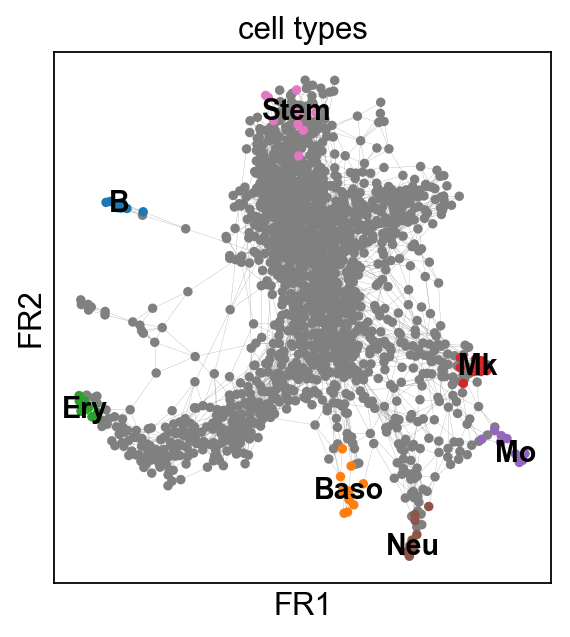

In [5]:
sc.pl.draw_graph(adata, color='cell_types', edges=True, legend_loc='on data')

In [6]:
adata.write(results_file)

Export for comparison with Monocle 2.

In [7]:
adata_raw = sc.read('./data/nestorowa_corrected_log2_transformed_counts.txt', cache=True)
adata_raw.uns['cell_types_colors'] = adata.uns['cell_types_colors']
adata_raw.write_csvs(results_file[:-3] + '_raw')

... reading from cache file ./cache/data-nestorowa_corrected_log2_transformed_counts.h5ad


## PAGA

We use the same number of neighbors as for visualizing the data above and as in [*paul15*](../paul15).

In [2]:
adata = sc.read(results_file)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.16) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


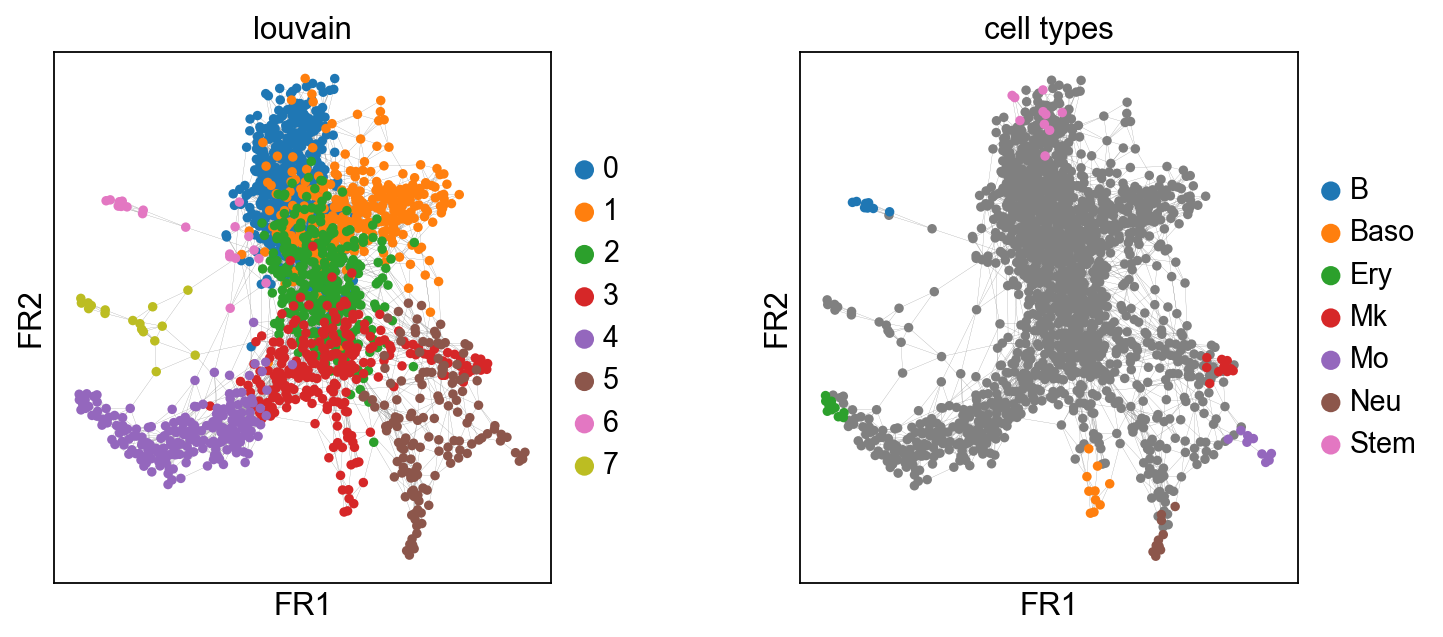

In [3]:
sc.tl.louvain(adata, resolution=0.6)
sc.pl.draw_graph(adata, color=['louvain', 'cell_types'], edges=True)

Let's resolve cluster 3 and 5 at a higher resolution.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.25) --> found 6 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


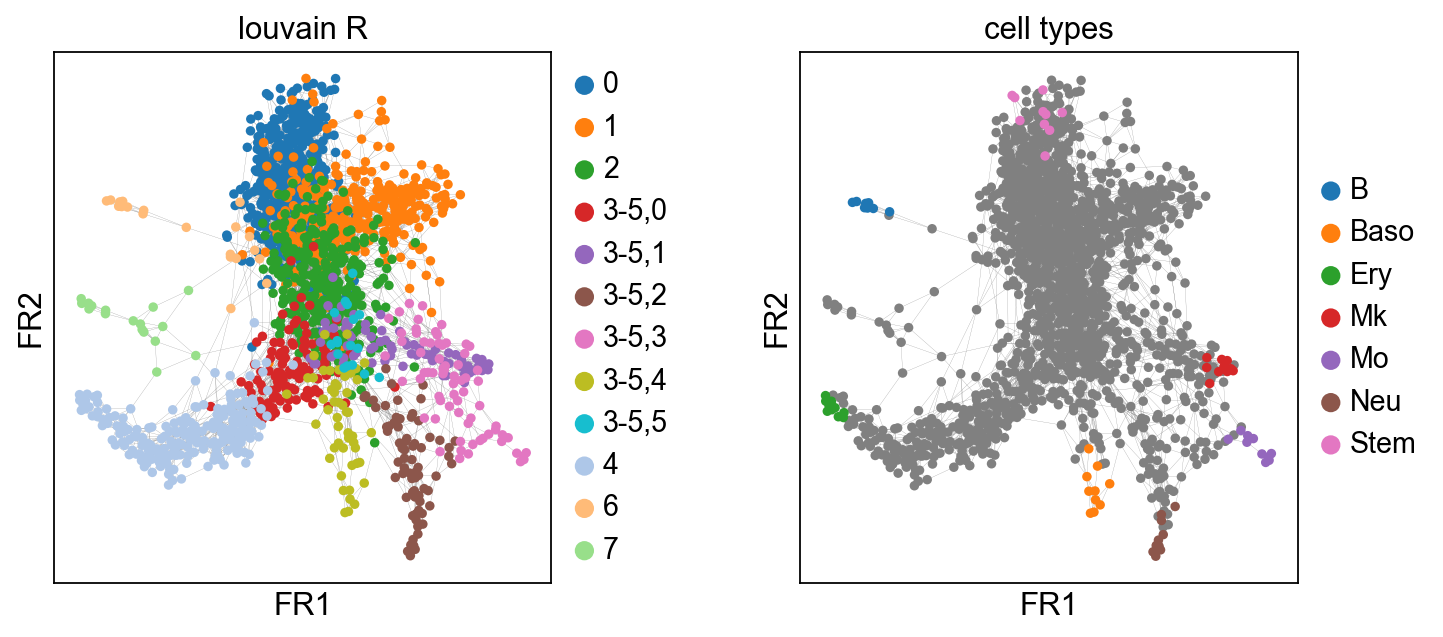

In [4]:
sc.tl.louvain(adata, resolution=0.6, restrict_to=('louvain', ['3', '5']))
sc.pl.draw_graph(adata, color=['louvain_R', 'cell_types'], edges=True)

Compute the connectivity of the reclustered graph.

In [5]:
sc.tl.paga(adata, groups='louvain_R')

running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:00.04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


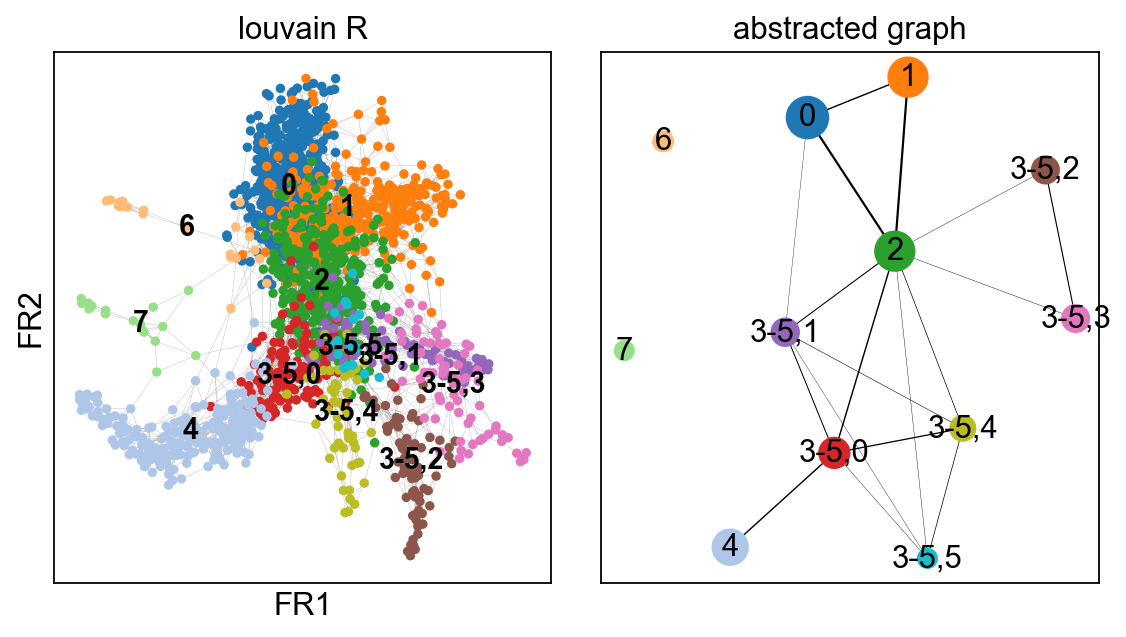

In [6]:
sc.pl.paga_compare(adata, basis='X_draw_graph_fr', threshold_solid=0.02)

In [13]:
aga_groups = adata.uns['paga']['groups']
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='cell_types', normalization='prediction', max_n_names=2)
asso_colors = sc.utils.get_associated_colors_of_groups(adata.uns['cell_types_colors'], asso_matrix)

Ignoring category 'no_gate' as it's in `settings.categories_to_ignore`.


In [14]:
new_asso_colors = []
for i, color_dict in enumerate(asso_colors):
    for c, v in color_dict.items():
        if v > 0 and c != 'grey':
            new_asso_colors.append(c)
    if len(new_asso_colors) < i+1:
        new_asso_colors.append('grey')

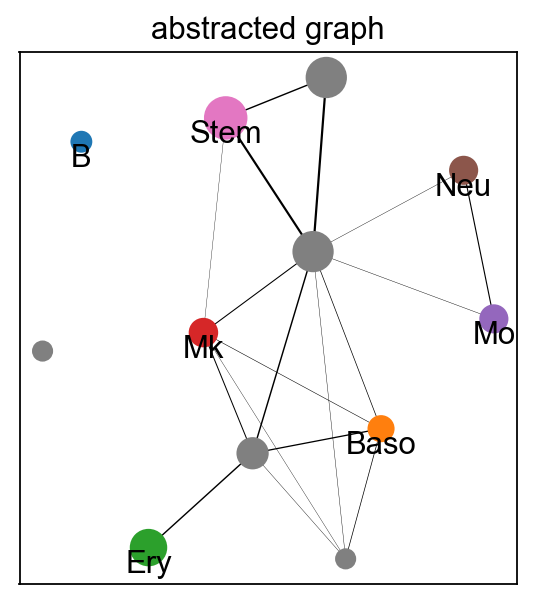

In [15]:
sc.pl.paga(adata, layout='fr', color=new_asso_colors, groups=asso_names, threshold_solid=0.02)

## Reconstruct gene changes for some marker genes.

In order to compute a pseudotime, add a root cell to the object.

In [16]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_types'] == 'Stem')[0]

In [17]:
sc.tl.dpt(adata)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.         0.9908838  0.9889698  0.98685133 0.9855362  0.98314196
     0.97727364 0.9726592  0.96813554 0.9632835 ]
    finished (0:00:00.3) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


Some marker genes.

| cell type | marker |
| --- | --- |
| Erythroids | Gata1, Gypa, Hba-a2, Hba-a1 |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Prss34, Ms4a2, Fcer1a, Siglecf |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Neutrophils | Elane, Ctsg, Mpo, Gfi1 | 
|B cells | Cd19, Vpreb2, Cd79a |

In [18]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

In [19]:
adata_raw = nestorowa16()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... reading from cache file ./cache/data-nestorowa_corrected_log2_transformed_counts.h5ad


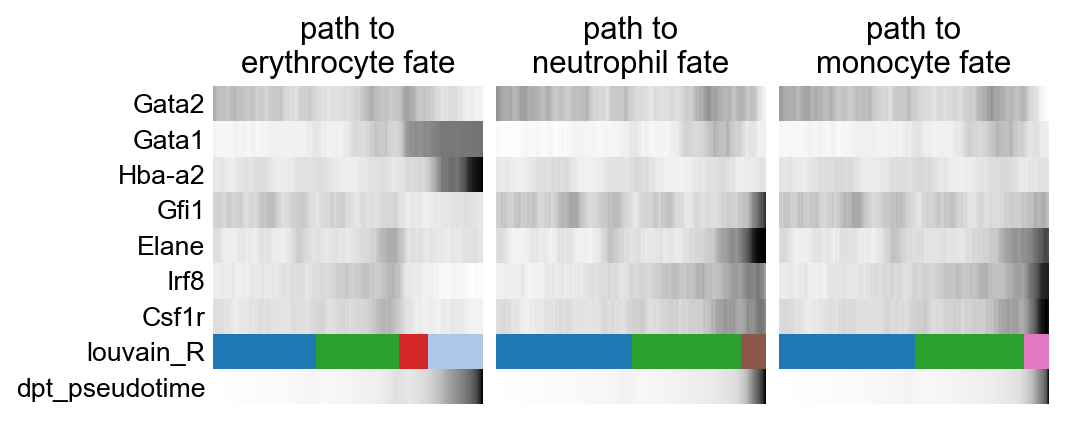

In [20]:
paths = [('erythrocytes', ['0', '2', '3-5,0', '4']),
         ('neutrophils', ['0', '2', '3-5,2']),
         ('monocytes', ['0', '2', '3-5,3'])]

_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                             
        groups_key='louvain_R',
        ax=axs[ipath],
        ytick_fontsize=12,
        show_node_names=False,
        left_margin=0.15,
        n_avg=50,
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',                             
        title='path to\n{} fate'.format(descr[:-1]),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path.png')
pl.show()